# BBM469 : Data Intensive Applications Lab. Assignment 3
21827497 - Alperen Berk IŞILDAR
21827373 - Uğurcan ERDOĞAN
#### Pre-Note
###### Graphs and Tables will be updated on new run.


## Purpose <a class="anchor" id="purpose"></a>


### PROBLEM DEFINITION :
In this assignment, we were asked to understand the classification and clustering algorithms using Apache Spark library for Python and perform a basic experiment with appropriate datasets. We have also dealt with data manipulation and data normalization.

##### Packages

In [ ]:
# Importing the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")

# Setting the objects spark and sc as stated in DataCamp
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Data Understanding<a class="anchor" id="data_understanding"></a>

In [4]:
# Setting up rdd file and check if we created it correctly
fileName = "data.csv"
fileRDD = sc.textFile(fileName)
print("File path is: ", fileName)
print(fileRDD.take(5))

File path is:  data.csv
['Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class', '28395,610.291,208.1781167,173.888747,1.197191424,0.549812187,28715,190.1410973,0.763922518,0.988855999,0.958027126,0.913357755,0.007331506,0.003147289,0.834222388,0.998723889,SEKER', '28734,638.018,200.5247957,182.7344194,1.097356461,0.411785251,29172,191.2727505,0.783968133,0.984985603,0.887033637,0.953860842,0.006978659,0.003563624,0.909850506,0.998430331,SEKER', '29380,624.11,212.8261299,175.9311426,1.209712656,0.562727317,29690,193.4109041,0.778113248,0.989558774,0.947849473,0.908774239,0.007243912,0.003047733,0.825870617,0.999066137,SEKER', '30008,645.884,210.557999,182.5165157,1.153638059,0.498615976,30724,195.4670618,0.782681273,0.976695743,0.903936374,0.928328835,0.007016729,0.003214562,0.861794425,0.994198849,SEKER']


In [5]:
# Creating data frame from given csv file and check it
OD = spark.read.csv(fileName, header=True, inferSchema=True)
OD.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|SEKER|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

### Word Count (Task 1)

In [6]:
# in order not to spoil data frame we have, created a new data frame and split by "," to create an array includes eah element in the rdd
# and take a look at to the top.
wordCountRDD = fileRDD.flatMap(lambda f: f.split(","))
wordCountRDD.take(20)

['Area',
 'Perimeter',
 'MajorAxisLength',
 'MinorAxisLength',
 'AspectRation',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Extent',
 'Solidity',
 'roundness',
 'Compactness',
 'ShapeFactor1',
 'ShapeFactor2',
 'ShapeFactor3',
 'ShapeFactor4',
 'Class',
 '28395',
 '610.291',
 '208.1781167']

In [7]:
# rdd is done as key value pairs and take a look at
wordCountRDD = wordCountRDD.map(lambda f: (f,1))
wordCountRDD.take(20)

[('Area', 1),
 ('Perimeter', 1),
 ('MajorAxisLength', 1),
 ('MinorAxisLength', 1),
 ('AspectRation', 1),
 ('Eccentricity', 1),
 ('ConvexArea', 1),
 ('EquivDiameter', 1),
 ('Extent', 1),
 ('Solidity', 1),
 ('roundness', 1),
 ('Compactness', 1),
 ('ShapeFactor1', 1),
 ('ShapeFactor2', 1),
 ('ShapeFactor3', 1),
 ('ShapeFactor4', 1),
 ('Class', 1),
 ('28395', 1),
 ('610.291', 1),
 ('208.1781167', 1)]

In [8]:
# sum up the values that have the same values and sort them by using the values and take a look at
wordCountRDD = wordCountRDD.reduceByKey(lambda f,h: f+h)
wordCountRDD = wordCountRDD.sortBy(lambda f: f[1], ascending=False)
wordCountRDD.take(7)

[('DERMASON', 3546),
 ('SIRA', 2636),
 ('SEKER', 2027),
 ('HOROZ', 1928),
 ('CALI', 1630),
 ('BARBUNYA', 1322),
 ('BOMBAY', 522)]

In [9]:
#Checking if the rdd file is created correctly and total line count
print("fileRDD type is: ", type(fileRDD))
print("Total number of lines is: ", fileRDD.count())

fileRDD type is:  <class 'pyspark.rdd.RDD'>
Total number of lines is:  13612


In [10]:
#total number of rows
print("total number of rows:", OD.count())


total number of rows: 13611


In [11]:
#Checking the column values' types
OD.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- Class: string (nullable = true)



In [12]:
print("Average values of each column is: ")
OD.agg({
    'Area': 'avg',
    'Perimeter': 'avg',
    'MajorAxisLength': 'avg',
    'MinorAxisLength': 'avg',
    'AspectRation': 'avg',
    'Eccentricity': 'avg',
    'ConvexArea': 'avg',
    'EquivDiameter': 'avg',
    'Extent': 'avg',
    'Solidity': 'avg',
    'roundness': 'avg',
    'Compactness':'avg',
    'ShapeFactor1':'avg',
    'ShapeFactor2':'avg',
    'ShapeFactor3':'avg',
    'ShapeFactor4':'avg'
}).show()

Average values of each column is: 
+-----------------+------------------+------------------+--------------------+------------------+------------------+-----------------+--------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+
|   avg(roundness)|         avg(Area)|avg(EquivDiameter)|avg(MinorAxisLength)|  avg(Compactness)| avg(ShapeFactor3)|  avg(ConvexArea)|   avg(ShapeFactor2)|avg(Eccentricity)| avg(AspectRation)|   avg(Perimeter)|       avg(Extent)| avg(ShapeFactor4)|     avg(Solidity)|avg(MajorAxisLength)|   avg(ShapeFactor1)|
+-----------------+------------------+------------------+--------------------+------------------+------------------+-----------------+--------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+
|0.873281831305413|53048.2845492616

In [13]:
print("Min values of each column is: ")
OD.agg({
    'Area': 'min',
    'Perimeter': 'min',
    'MajorAxisLength': 'min',
    'MinorAxisLength': 'min',
    'AspectRation': 'min',
    'Eccentricity': 'min',
    'ConvexArea': 'min',
    'EquivDiameter': 'min',
    'Extent': 'min',
    'Solidity': 'min',
    'roundness': 'min',
    'Compactness':'min',
    'ShapeFactor1':'min',
    'ShapeFactor2':'min',
    'ShapeFactor3':'min',
    'ShapeFactor4':'min'
}).show()

Min values of each column is: 
+--------------+---------+------------------+--------------------+----------------+-----------------+---------------+-----------------+-----------------+-----------------+--------------+-----------+-----------------+-------------+--------------------+-----------------+
|min(roundness)|min(Area)|min(EquivDiameter)|min(MinorAxisLength)|min(Compactness)|min(ShapeFactor3)|min(ConvexArea)|min(ShapeFactor2)|min(Eccentricity)|min(AspectRation)|min(Perimeter)|min(Extent)|min(ShapeFactor4)|min(Solidity)|min(MajorAxisLength)|min(ShapeFactor1)|
+--------------+---------+------------------+--------------------+----------------+-----------------+---------------+-----------------+-----------------+-----------------+--------------+-----------+-----------------+-------------+--------------------+-----------------+
|   0.489618256|    20420|       161.2437642|         122.5126535|     0.640576759|      0.410338584|          20684|       5.64169E-4|      0.218951263|      

In [14]:
print("Max values of each column is: ")
OD.agg({
    'Area': 'max',
    'Perimeter': 'max',
    'MajorAxisLength': 'max',
    'MinorAxisLength': 'max',
    'AspectRation': 'max',
    'Eccentricity': 'max',
    'ConvexArea': 'max',
    'EquivDiameter': 'max',
    'Extent': 'max',
    'Solidity': 'max',
    'roundness': 'max',
    'Compactness':'max',
    'ShapeFactor1':'max',
    'ShapeFactor2':'max',
    'ShapeFactor3':'max',
    'ShapeFactor4':'max'
}).show()

Max values of each column is: 
+--------------+---------+------------------+--------------------+----------------+-----------------+---------------+-----------------+-----------------+-----------------+--------------+-----------+-----------------+-------------+--------------------+-----------------+
|max(roundness)|max(Area)|max(EquivDiameter)|max(MinorAxisLength)|max(Compactness)|max(ShapeFactor3)|max(ConvexArea)|max(ShapeFactor2)|max(Eccentricity)|max(AspectRation)|max(Perimeter)|max(Extent)|max(ShapeFactor4)|max(Solidity)|max(MajorAxisLength)|max(ShapeFactor1)|
+--------------+---------+------------------+--------------------+----------------+-----------------+---------------+-----------------+-----------------+-----------------+--------------+-----------+-----------------+-------------+--------------------+-----------------+
|     0.9906854|   254616|       569.3743583|         460.1984968|     0.987302969|      0.974767153|         263261|      0.003664972|      0.911422968|      

DERMASON samples make up 26.05 % of the dataset.
SIRA samples make up 19.37 % of the dataset.
SEKER samples make up 14.89 % of the dataset.
HOROZ samples make up 14.17 % of the dataset.
CALI samples make up 11.98 % of the dataset.
BARBUNYA samples make up 9.71 % of the dataset.
BOMBAY samples make up 3.84 % of the dataset.


<AxesSubplot:xlabel='Class', ylabel='count'>

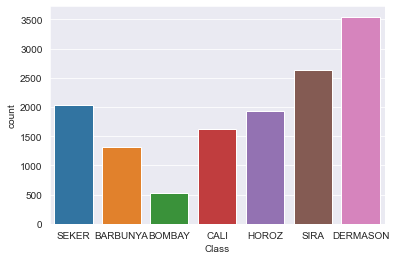

In [15]:
# Percentage of the classes
print("DERMASON samples make up", round(wordCountRDD.take(7)[0][1] / OD.count()* 100, 2), "% of the dataset.")
print("SIRA samples make up", round(wordCountRDD.take(7)[1][1] / OD.count()* 100, 2), "% of the dataset.")
print("SEKER samples make up", round(wordCountRDD.take(7)[2][1] / OD.count()* 100, 2), "% of the dataset.")
print("HOROZ samples make up", round(wordCountRDD.take(7)[3][1] / OD.count()* 100, 2), "% of the dataset.")
print("CALI samples make up", round(wordCountRDD.take(7)[4][1] / OD.count()* 100, 2), "% of the dataset.")
print("BARBUNYA samples make up", round(wordCountRDD.take(7)[5][1] / OD.count()* 100, 2), "% of the dataset.")
print("BOMBAY samples make up", round(wordCountRDD.take(7)[6][1] / OD.count()* 100, 2), "% of the dataset.")
# Plotting results
sns.countplot(x="Class", data=OD.toPandas())

## Data Preparation<a class="anchor" id="data_preparation"></a>

In [16]:
# "Class" column has categorical string values and this makes our model cannot be trained
# We are using StringIndexer to handle this situation.
# and also drop the "Class" column..

from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Class", outputCol="ClassIndex")
OD = indexer.fit(OD).transform(OD)
OD = OD.drop("Class")
OD.show()

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+----------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|ClassIndex|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+----------+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|       2.0|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.0

 StringIndexer indexes categorical variables by their frequency so in this case:
 0: DERMASON, 1: SIRA, 2: SEKER, 3: HOROZ, 4: CALI, 5: BARBUNYA, 6: BOMBAY

In [17]:
# As we can see above, some values are null so we should drop that rows all.
# We googled that why are nullables true still but we found that PySpark dataframes has a bug for nullables bool values.
# We can check the number of total rows and compare it to the default number of rows and we can see that data has no null values
OD = OD.na.drop(how='any')
OD.printSchema()

print("Total sample number: {}".format(OD.count()))

root
 |-- Area: integer (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- ClassIndex: double (nullable = false)

Total sample number: 13611


In [18]:
from pyspark.sql.types import DoubleType

# All of the columns have double values except by "Area" and "ConvexArea" so we should convert them into double too.

OD = OD.withColumn("Area", OD["Area"].cast(DoubleType()))
OD = OD.withColumn("ConvexArea", OD["ConvexArea"].cast(DoubleType()))
OD.printSchema()

root
 |-- Area: double (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: double (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- ClassIndex: double (nullable = false)



In [19]:
from pyspark.sql.types import FloatType
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

ND = OD.select("*")

# Creating normalized dataset(ND)
columns_to_normalize = ["Area", "EquivDiameter", "MinorAxisLength", "ConvexArea", "AspectRation", "Perimeter", "MajorAxisLength"]
assembler = [VectorAssembler(inputCols=[col], outputCol=col+"_Vect") for col in columns_to_normalize]
scaler = [MinMaxScaler(inputCol=col+"_Vect", outputCol=col+"_Scaled") for col in columns_to_normalize]
pipeline = Pipeline(stages=assembler + scaler)

NDModel = pipeline.fit(ND)
ND = NDModel.transform(ND)

for col in columns_to_normalize:
    ND = ND.drop(col+"_Vect")
    ND = ND.drop(col)


firstElem = F.udf(lambda v: float(v[0]), FloatType())
NDX = ND.select([firstElem(col+"_Scaled").alias(col+"_Scaled") for col in columns_to_normalize])
for col in columns_to_normalize:
    NDX = NDX.withColumn(col+"_Scaled", F.col(col+"_Scaled").cast(DoubleType()))

for col in columns_to_normalize:
    ND = ND.drop(col+"_Scaled")

def append_ODs(df2,df3):
    DF1 = df2.withColumn("row_id", F.monotonically_increasing_id())
    DF2 = df3.withColumn("row_id", F.monotonically_increasing_id())
    result_df = DF1.join(DF2, ("row_id")).drop("row_id")
    return result_df

ND = append_ODs(ND,NDX)
ND.show()
ND.printSchema()

+------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+----------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+----------------------+
|Eccentricity|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|ClassIndex|         Area_Scaled|EquivDiameter_Scaled|MinorAxisLength_Scaled|   ConvexArea_Scaled| AspectRation_Scaled|    Perimeter_Scaled|MajorAxisLength_Scaled|
+------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+----------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+----------------------+
| 0.549812187|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|       2.0| 0.03405267372727394| 0.07080413401126862|  

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

In [59]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA

feat_cols = []

for i in OD.columns:
    OD = OD.withColumn(i, F.col(i).cast("float"))

for i in OD.schema.names:
    if i != "ClassIndex":
        feat_cols.append(i)

x_OD = OD.select(feat_cols)
vec_assembler_OD = VectorAssembler(inputCols = x_OD.schema.names, outputCol='features')
final_data_OD = vec_assembler_OD.transform(x_OD)

kmeans_OD = KMeans(featuresCol="features",k=7)
kmeans_model_OD = kmeans_OD.fit(final_data_OD)
kmeans_final_OD = kmeans_model_OD.transform(final_data_OD)

pca_OD = PCA(k=2, inputCol="features", outputCol="pca")
pca_model_OD = pca_OD.fit(final_data_OD)
pca_final_OD = pca_model_OD.transform(final_data_OD)
x_pca_OD = np.array(pca_final_OD.rdd.map(lambda row: row.pca).collect())
x_kmeans_OD = np.array(OD.rdd.map(lambda row: row.ClassIndex).collect()).reshape(-1,1)

In [60]:
feat_cols = []

for i in ND.columns:
    ND = ND.withColumn(i, F.col(i).cast("float"))

for i in ND.schema.names:
    if i != "ClassIndex":
        feat_cols.append(i)
x_ND = ND.select(feat_cols)
vec_assembler_ND = VectorAssembler(inputCols = x_ND.schema.names, outputCol='features')
final_data_ND = vec_assembler_ND.transform(x_ND)

kmeans_ND = KMeans(featuresCol="features",k=7)
kmeans_model_ND = kmeans_ND.fit(final_data_ND)
kmeans_final_ND = kmeans_model_ND.transform(final_data_ND)

pca_ND = PCA(k=2, inputCol="features", outputCol="pca")
pca_model_ND = pca_ND.fit(final_data_ND)
pca_final_ND = pca_model_ND.transform(final_data_ND)

x_pca_ND = np.array(pca_final_ND.rdd.map(lambda row: row.pca).collect())
x_kmeans_ND = np.array(ND.rdd.map(lambda row: row.ClassIndex).collect()).reshape(-1,1)

In [61]:
#set Clustered Original Dataset(COD)



In [62]:
#set Clustered Normalized Dataset(CND)


In [63]:
feat_cols = []
COD = OD.select("*")
COD = COD.drop("ClassIndex")
for i in COD.schema.names:
    if i != "ClassIndex":
        feat_cols.append(i)

x_COD = COD.select(feat_cols)
vec_assembler_COD = VectorAssembler(inputCols = x_COD.schema.names, outputCol='features')
final_data_COD = vec_assembler_COD.transform(x_COD)

kmeans_COD = KMeans(featuresCol="features",k=7)
kmeans_model_COD = kmeans_COD.fit(final_data_COD)
kmeans_final_COD = kmeans_model_COD.transform(final_data_COD)

COD = append_ODs(COD, kmeans_final_COD.select("prediction"))
COD = COD.withColumnRenamed("prediction", "ClassIndex")
COD.show(5)

pca_COD = PCA(k=2, inputCol="features", outputCol="pca")
pca_model_COD = pca_COD.fit(final_data_COD)
pca_final_COD = pca_model_COD.transform(final_data_COD)
x_pca_COD = np.array(pca_final_COD.rdd.map(lambda row: row.pca).collect())
x_kmeans_COD = np.array(kmeans_final_COD.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

+-------+---------+---------------+---------------+------------+------------+----------+-------------+----------+----------+----------+-----------+------------+------------+------------+------------+----------+
|   Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|    Extent|  Solidity| roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|ClassIndex|
+-------+---------+---------------+---------------+------------+------------+----------+-------------+----------+----------+----------+-----------+------------+------------+------------+------------+----------+
|28395.0|  610.291|      208.17812|      173.88875|   1.1971915|   0.5498122|   28715.0|     190.1411| 0.7639225|  0.988856| 0.9580271| 0.91335773| 0.007331506| 0.003147289|   0.8342224|  0.99872386|         2|
|28734.0|  638.018|       200.5248|      182.73442|   1.0973564|  0.41178524|   29172.0|    191.27275|0.78396815| 0.9849856|0.88703364|  0.9538608| 0.006978

In [64]:
feat_cols = []
CND = ND.select("*")
CND = CND.drop("ClassIndex")
for i in CND.columns:
    CND = CND.withColumn(i, F.col(i).cast("float"))

for i in CND.schema.names:
    if i != "ClassIndex":
        feat_cols.append(i)
x_CND = CND.select(feat_cols)
vec_assembler_CND = VectorAssembler(inputCols = x_CND.schema.names, outputCol='features')
final_data_CND = vec_assembler_CND.transform(x_CND)

kmeans_CND = KMeans(featuresCol="features",k=7)
kmeans_model_CND = kmeans_CND.fit(final_data_CND)
kmeans_final_CND = kmeans_model_CND.transform(final_data_CND)

CND = append_ODs(CND, kmeans_final_CND.select("prediction"))
CND = CND.withColumnRenamed("prediction", "ClassIndex")
CND.show(5)

pca_CND = PCA(k=2, inputCol="features", outputCol="pca")
pca_model_CND = pca_CND.fit(final_data_CND)
pca_final_CND = pca_model_CND.transform(final_data_CND)

x_pca_CND = np.array(pca_final_CND.rdd.map(lambda row: row.pca).collect())
x_kmeans_CND = np.array(kmeans_final_CND.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

+------------+----------+----------+----------+-----------+------------+------------+------------+------------+-----------+--------------------+----------------------+-----------------+-------------------+----------------+----------------------+----------+
|Eccentricity|    Extent|  Solidity| roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Area_Scaled|EquivDiameter_Scaled|MinorAxisLength_Scaled|ConvexArea_Scaled|AspectRation_Scaled|Perimeter_Scaled|MajorAxisLength_Scaled|ClassIndex|
+------------+----------+----------+----------+-----------+------------+------------+------------+------------+-----------+--------------------+----------------------+-----------------+-------------------+----------------+----------------------+----------+
|   0.4962633| 0.7771105| 0.9878478| 0.9249086| 0.93140197| 0.006804053| 0.003158611|  0.86750966|    0.999237|0.048177596|          0.09719423|            0.19177528|       0.04703249|         0.09034743|      0.09007664|       

## Clustering results<a class="anchor" id="clustering"></a>

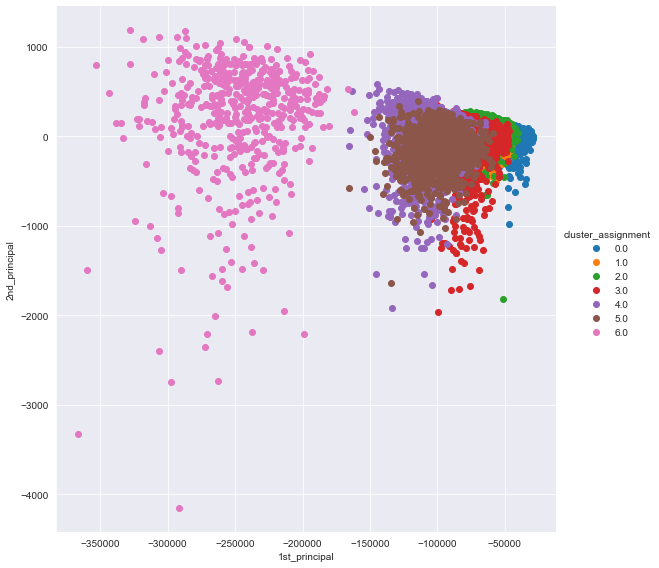

In [65]:
pca_data_OD = np.hstack((x_pca_OD, x_kmeans_OD))
pca_df_OD = pd.DataFrame(data=pca_data_OD, columns=("1st_principal", "2nd_principal", "cluster_assignment"))
sns.FacetGrid(pca_df_OD, hue="cluster_assignment", size=8).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()

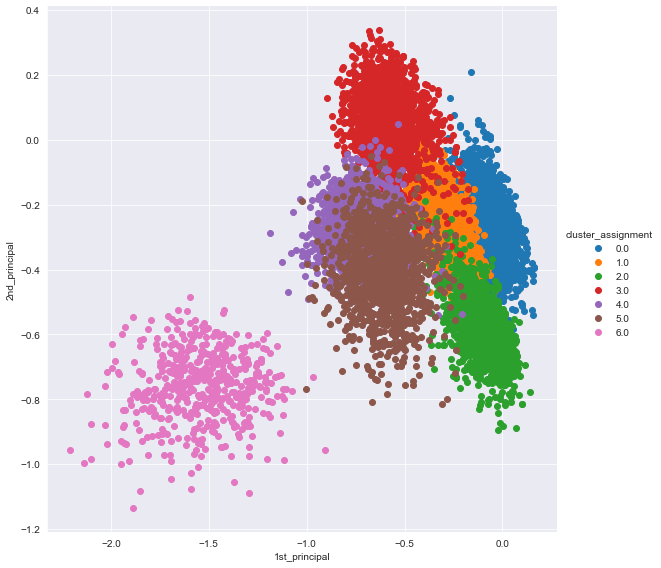

In [66]:
pca_data_ND = np.hstack((x_pca_ND, x_kmeans_ND))
pca_df_ND = pd.DataFrame(data=pca_data_ND, columns=("1st_principal", "2nd_principal", "cluster_assignment"))
sns.FacetGrid(pca_df_ND, hue="cluster_assignment", size=8).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()

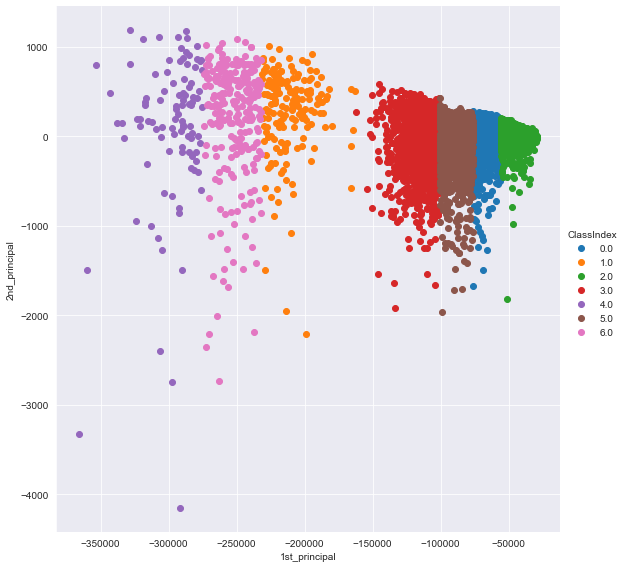

In [48]:
pca_data_COD = np.hstack((x_pca_COD, x_kmeans_COD))
pca_df_COD = pd.DataFrame(data=pca_data_COD, columns=("1st_principal", "2nd_principal", "ClassIndex"))
sns.FacetGrid(pca_df_COD, hue="ClassIndex", size=8).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()

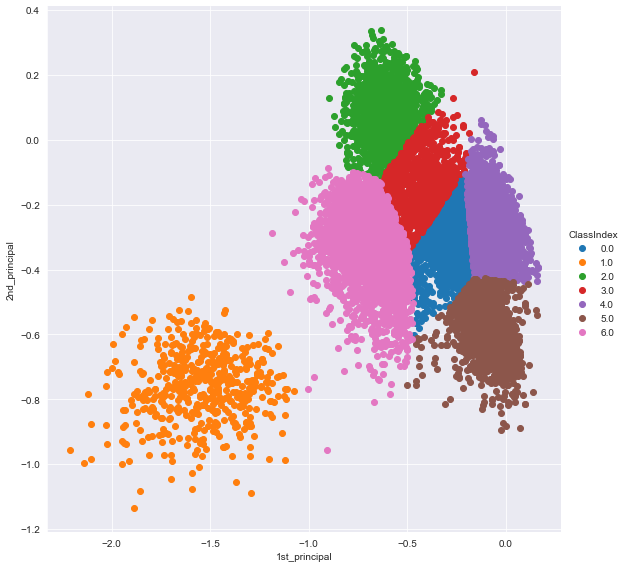

In [49]:
pca_data_CND = np.hstack((x_pca_CND, x_kmeans_CND))
pca_df_CND = pd.DataFrame(data=pca_data_CND, columns=("1st_principal", "2nd_principal", "ClassIndex"))
sns.FacetGrid(pca_df_CND, hue="ClassIndex", size=8).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

In [32]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def classification_helper(data):
    feat_cols_df = []
    for i in data.schema.names:
        if i != "ClassIndex":
            feat_cols_df.append(i)


    assembler = VectorAssembler(inputCols=feat_cols_df,outputCol="features")
    output = assembler.transform(data)
    final_data_rfc = output.select('features','ClassIndex')

    (training_data, test_data) = final_data_rfc.randomSplit([0.8, 0.2])

    maxDepthList= list(range(5,21,5))

    accuracy_list = []
    rfc_predictions_list = []
    for i in maxDepthList:

        rfc = RandomForestClassifier(labelCol='ClassIndex',featuresCol='features',maxDepth=i)

        rfc_model = rfc.fit(final_data_rfc)
        rfc_predictions = rfc_model.transform(test_data)
        rfc_predictions_list.append(rfc_predictions)
        # Select (prediction, true label) and compute test error
        rfc_evaluator = MulticlassClassificationEvaluator(labelCol="ClassIndex", predictionCol="prediction", metricName="accuracy")
        accuracy = rfc_evaluator.evaluate(rfc_predictions)
        accuracy_list.append(accuracy*100)
        print("Accuracy for our dataset is : {:.2f}%".format(accuracy*100))

    print("The best accuracy score is: {:.2f}% --- Optimal Max Depth hyperparameter: {} ".format(max(accuracy_list),(accuracy_list.index(max(accuracy_list))+1)*5))

    plt.plot(maxDepthList, accuracy_list)
    plt.title("Max Depth Scores")
    plt.xlabel("Max Depth value")
    plt.ylabel("Score")
    plt.legend(["OD","ND","COD","CND"])

    max_score_prediction = rfc_predictions_list.pop(accuracy_list.index(max(accuracy_list)))
    #important: need to cast to float type, and order by prediction, else it won't work
    preds_and_labels = max_score_prediction.select(['prediction','ClassIndex']).withColumn('ClassIndex', F.col('ClassIndex').cast(FloatType())).orderBy('prediction')

    #select only prediction and label columns
    preds_and_labels = preds_and_labels.select(['prediction','ClassIndex'])

    metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

    print("===Multiclass Confusion Matrix===")
    print(metrics.confusionMatrix().toArray())

    return accuracy_list



## Classification results <a class="anchor" id="classificationmodel"></a>

Accuracy for our dataset is : 88.41%
Accuracy for our dataset is : 94.36%
Accuracy for our dataset is : 98.97%
Accuracy for our dataset is : 99.61%
The best accuracy score is: 99.61% --- Optimal Max Depth hyperparameter: 20 
===Multiclass Confusion Matrix===
[[757.   0.   0.   0.   0.   0.   0.]
 [  3. 526.   0.   0.   0.   0.   0.]
 [  1.   1. 409.   0.   0.   0.   0.]
 [  0.   2.   0. 412.   2.   0.   0.]
 [  0.   1.   0.   0. 322.   0.   0.]
 [  0.   1.   0.   0.   0. 257.   0.]
 [  0.   0.   0.   0.   0.   0. 109.]]
Accuracy for our dataset is : 88.92%
Accuracy for our dataset is : 95.42%
Accuracy for our dataset is : 99.02%
Accuracy for our dataset is : 99.59%
The best accuracy score is: 99.59% --- Optimal Max Depth hyperparameter: 20 
===Multiclass Confusion Matrix===
[[708.   0.   0.   0.   0.   0.   0.]
 [  3. 519.   0.   0.   0.   0.   0.]
 [  1.   1. 378.   0.   0.   0.   0.]
 [  1.   2.   0. 382.   0.   0.   0.]
 [  0.   1.   0.   1. 314.   0.   0.]
 [  0.   1.   0.   0.   0

[97.0272206303725, 99.17621776504298, 99.89255014326648, 100.0]

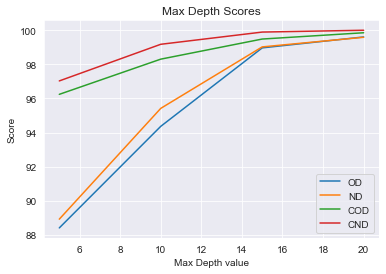

In [33]:
classification_helper(OD)
classification_helper(ND)
classification_helper(COD)
classification_helper(CND)

For detailed explanation/interpration and references, check assignment report out.